# INTENT CLASSIFICATION

## PROJECT WORK #2 - NLP - FEUP
### Filippo Comastri - Benedek Lellei - Amanda Oliveira 

The problem consists of classify queries into different intent classes. Queries are very short sentences, usually some questions or prompt commands about specific topics.

The propose of the project is to try large pretrained language models to accomlish the above task and compare the results with those of basic natural language processing techniques and "traditional" machine learning classification methods tried with the first assignment.

We tried four different models found on Huggingface to see the performance of trasformer-based deep neural networks.

## Imports

In [1]:
! pip install datasets transformers accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━

In [2]:
import pandas as pd
from datasets import load_dataset
import json
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForMaskedLM
from transformers import pipeline
from transformers import TextClassificationPipeline
from transformers import DataCollatorForLanguageModeling
from datasets import load_metric
import numpy as np
import math
from huggingface_hub import notebook_login
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Loading dataset

In [5]:
# If you're using Colab, you need to upload the file data_full.json in the runtime

def get_df_hf(oos=False) :
    with open('data_full.json') as json_file: 
        data_dict = json.load(json_file) 

    train_data = data_dict['train']
    val_data = data_dict['val']
    test_data = data_dict['test']

    oos_train = data_dict['oos_train']
    oos_val = data_dict['oos_val']
    oos_test = data_dict['oos_test']


    train_df = pd.DataFrame(train_data, columns =['query', 'label'])
    val_df = pd.DataFrame(val_data, columns =['query', 'label'])
    test_df = pd.DataFrame(test_data, columns =['query', 'label'])

    train_oos_df = pd.DataFrame(oos_train,columns=['query','label'])
    val_oos_df = pd.DataFrame(oos_val,columns=['query','label'])
    test_oos_df = pd.DataFrame(oos_test,columns=['query','label'])

    if oos :
        # Concatenate dataframes to consider oos as a specific intent
        train_df = pd.concat([train_df,train_oos_df])
        val_df = pd.concat([val_df,val_oos_df])
        test_df = pd.concat([test_df,test_oos_df])

    unique_labels = train_df['label'].unique()
    labels_dict = {i: v for i, v in enumerate(unique_labels)}

    train_df['label'], _ = pd.factorize(train_df['label'])
    val_df['label'], _ = pd.factorize(val_df['label'])
    test_df['label'], _ = pd.factorize(test_df['label'])

    # Map the integer labels to string labels
    #df['label'] = label_mapping.take(df['label'])
    
    return Dataset.from_pandas(train_df), Dataset.from_pandas(val_df), Dataset.from_pandas(test_df), labels_dict

train_df, val_df, test_df, label_mapping = get_df_hf()
train_valid_test_dataset = DatasetDict({
    'train': train_df,
    'validation': val_df,
    'test': test_df
})

num_labels = 150

train_valid_test_dataset


DatasetDict({
    train: Dataset({
        features: ['query', 'label'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['query', 'label'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['query', 'label'],
        num_rows: 4500
    })
})

## Define preprocessing and evaluation functions

In [59]:
accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")

# we only want to display accuracy during the training process
def compute_metrics_train(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return accuracy_metric.compute(predictions=predictions, references=labels)

# we will display all four metrics (used during the first assignment)
def compute_metrics_eval(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="macro") 
    recall = recall_metric.compute(predictions=predictions, references=labels, average="macro") 
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro") 
    return { "accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1 }

# preprocessing function for training the classification head
def preprocess_function(sample):
    return tokenizer(sample["query"], truncation=True, padding=True, return_tensors='pt')

# preprocessing function for the domain adaptation fine-tuning
def preprocess_function_d_adapt(examples):
    result = tokenizer(examples["query"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

# Pre-processing function to apply before masked language modeling
chunk_size = 8

def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

# function to obtain the most commonly misclassified intent classes
def compare_misclassification(y_test, y_pred):
    # Generate a confusion matrix with label indices
    conf_matrix = confusion_matrix(y_test, y_pred)

    labels = sorted(list(set(y_test)))
    for class1_idx in range(len(labels)):
        for class2_idx in range(len(labels)):
            # Get the name the two classes
            class1 = labels[class1_idx]
            class2 = labels[class2_idx]
            if(class1 != class2):
                # Get the total number of samples 
                class1_queries = sum(conf_matrix[class1_idx])

                # Get the number of misclassifications 
                misclassifications_class1 = conf_matrix[class1_idx][class2_idx] 
                
                # Calculate the percentage of misclassifications 
                percent_misclassified = (misclassifications_class1 / class1_queries) * 100
                if percent_misclassified > 10.0:
                    print(f"Percentage of '"+ class1 + "' queries misclassified as'" + class2 + "': {:.2f}%".format(percent_misclassified))


## HugginFace login

We will need this login later to push the fine-tuned model on the hub.

In [100]:
notebook_login()

## *Distilled BERT* - the baseline

As a baseline we used distilled version of BERT (which was already used during the lesson) because it is a rather small model in terms of parameter count and yet can provide reasonable results.

#### Tokenizer

In [7]:
model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

In [8]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['query', 'label', 'input_ids', 'attention_mask'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['query', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['query', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4500
    })
})

#### Load the pretrained model

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, id2label = label_mapping)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

#### Fine-tune the classification head using a Trainer

In [10]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_train
)

In [11]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,4.326100,1.959851,0.840667
2,1.470900,0.760012,0.917333
3,0.620900,0.543852,0.935000


TrainOutput(global_step=2814, training_loss=1.830068185639534, metrics={'train_runtime': 202.1073, 'train_samples_per_second': 222.654, 'train_steps_per_second': 13.923, 'total_flos': 379476929590560.0, 'train_loss': 1.830068185639534, 'epoch': 3.0})

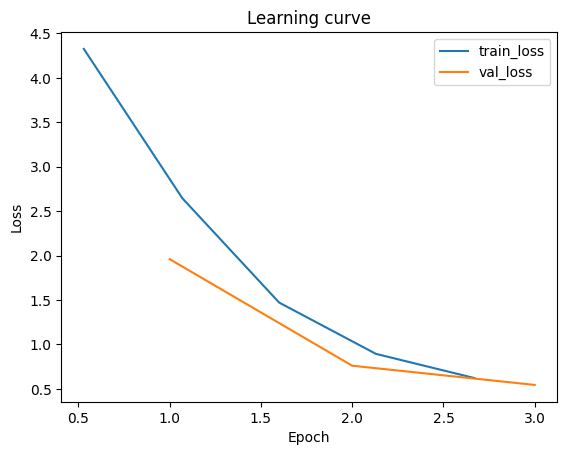

In [12]:
loss_values = [log_entry["loss"] for log_entry in trainer.state.log_history if "loss" in log_entry ]
epochs_train = [log_entry["epoch"] for log_entry in trainer.state.log_history if "loss" in log_entry and "epoch" in log_entry]
val_loss_values = [log_entry["eval_loss"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry ]
epochs_val =  [log_entry["epoch"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry and "epoch" in log_entry]

# Plot the loss graph
plt.plot(epochs_train,loss_values,label='train_loss')
plt.plot(epochs_val,val_loss_values,label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning curve")
plt.legend()
plt.show()

We plotted the validation and training loss to be sure that the model is not overfitting.

#### Saving the model

In [13]:
trainer.save_model()

#### Evaluate the model on the test dataset

In [14]:
tokenizer_loaded = AutoTokenizer.from_pretrained("./results")
model_loaded = AutoModelForSequenceClassification.from_pretrained("./results", num_labels=num_labels)

In [15]:
trainer2 = Trainer(
    model=model_loaded,
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer_loaded,
    data_collator=data_collator,
    compute_metrics=compute_metrics_eval
)

In [16]:
trainer2.evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.9288888888888889}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9326290438272785}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.928888888888889}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9281772325992623}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.5522355437278748,
 'eval_accuracy': {'accuracy': 0.9288888888888889},
 'eval_precision': {'precision': 0.9326290438272785},
 'eval_recall': {'recall': 0.928888888888889},
 'eval_f1': {'f1': 0.9281772325992623},
 'eval_runtime': 6.4823,
 'eval_samples_per_second': 694.202,
 'eval_steps_per_second': 86.852}

The results are already comparable with those achieved during the first assignment in all the metrics. Let's try fine-tuning the language model on our dataset!

#### Domain adaptation

In [17]:
model = AutoModelForMaskedLM.from_pretrained(model_name)

##### Tokenizer

In [18]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenized_datasets = train_valid_test_dataset.map(
    preprocess_function_d_adapt, batched=True, remove_columns=["query", "label"]
)
tokenized_datasets

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 4500
    })
})

##### Pre-processing dataset

In [20]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 20691
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 4112
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 6116
    })
})

In [21]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

##### Fine-tune

In [25]:
batch_size = 64
# Show the training loss with every epoch
logging_steps = len(lm_datasets["train"]) // batch_size
model_name = model_name.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-clinc150",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    fp16=True,
    logging_steps=logging_steps,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

Cloning https://huggingface.co/FilippoComastri/bert-large-uncased-finetuned-clinc150 into local empty directory.


Download file pytorch_model.bin:   0%|          | 7.40k/1.25G [00:00<?, ?B/s]

Download file runs/May04_11-34-09_72030e5b1bea/1683200082.2143476/events.out.tfevents.1683200082.72030e5b1bea.…

Download file runs/May04_11-34-09_72030e5b1bea/events.out.tfevents.1683200077.72030e5b1bea.163.3: 100%|#######…

Download file training_args.bin: 100%|##########| 3.56k/3.56k [00:00<?, ?B/s]

Clean file runs/May04_11-34-09_72030e5b1bea/1683200082.2143476/events.out.tfevents.1683200082.72030e5b1bea.163…

Clean file runs/May04_11-34-09_72030e5b1bea/events.out.tfevents.1683200077.72030e5b1bea.163.3:  17%|#7        …

Clean file training_args.bin:  28%|##8       | 1.00k/3.56k [00:00<?, ?B/s]

Download file runs/May04_11-34-09_72030e5b1bea/events.out.tfevents.1683200954.72030e5b1bea.163.5: 100%|#######…

Clean file runs/May04_11-34-09_72030e5b1bea/events.out.tfevents.1683200954.72030e5b1bea.163.5: 100%|##########…

Clean file pytorch_model.bin:   0%|          | 1.00k/1.25G [00:00<?, ?B/s]

In [26]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


>>> Perplexity: 319.56


In [27]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,3.729900,3.183496
2,3.092100,2.944874
3,2.877800,2.864294


TrainOutput(global_step=972, training_loss=3.2325474980436724, metrics={'train_runtime': 79.8815, 'train_samples_per_second': 777.063, 'train_steps_per_second': 12.168, 'total_flos': 128569822536672.0, 'train_loss': 3.2325474980436724, 'epoch': 3.0})

In [28]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 16.99


We can see that the perplexity dropped by a lot so the fine-tuning worked!

In [29]:
trainer.push_to_hub()

Upload file pytorch_model.bin:   0%|          | 1.00/256M [00:00<?, ?B/s]

Upload file runs/May24_10-18-37_01315b6119dc/events.out.tfevents.1684924114.01315b6119dc.332.3:   0%|         …

Upload file runs/May24_10-18-37_01315b6119dc/events.out.tfevents.1684924265.01315b6119dc.332.5:   0%|         …

To https://huggingface.co/FilippoComastri/bert-large-uncased-finetuned-clinc150
   0c8a3fb..441ecf6  main -> main

   0c8a3fb..441ecf6  main -> main

To https://huggingface.co/FilippoComastri/bert-large-uncased-finetuned-clinc150
   441ecf6..e494851  main -> main

   441ecf6..e494851  main -> main



'https://huggingface.co/FilippoComastri/bert-large-uncased-finetuned-clinc150/commit/441ecf69a5728634c61a9ce3b0b3827e3250a662'

##### Fine tune the classification head

In [30]:
checkpoint = 'FilippoComastri/distilbert-base-uncased-finetuned-clinc150'


tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label = label_mapping)

tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)

metric = load_metric("accuracy")

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_train
)

Some weights of the model checkpoint at FilippoComastri/distilbert-base-uncased-finetuned-clinc150 were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at FilippoComastri/distilbert-base-uncased-finetuned-clinc150 and are newly

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

In [31]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,4.256900,1.875548,0.860000
2,1.395900,0.706482,0.920000
3,0.579600,0.509707,0.936667


TrainOutput(global_step=2814, training_loss=1.7677027275991, metrics={'train_runtime': 198.1356, 'train_samples_per_second': 227.117, 'train_steps_per_second': 14.202, 'total_flos': 379476929590560.0, 'train_loss': 1.7677027275991, 'epoch': 3.0})

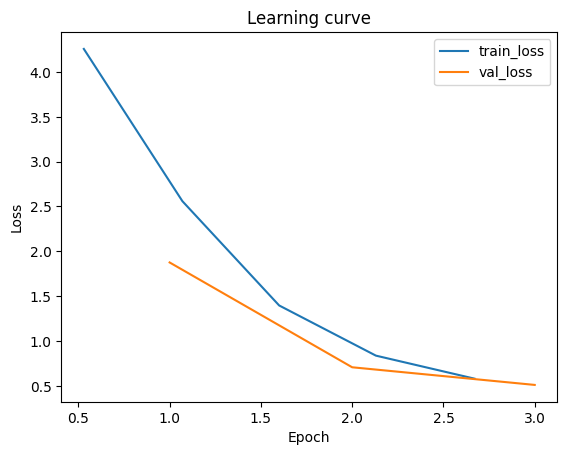

In [32]:
loss_values = [log_entry["loss"] for log_entry in trainer.state.log_history if "loss" in log_entry ]
epochs_train = [log_entry["epoch"] for log_entry in trainer.state.log_history if "loss" in log_entry and "epoch" in log_entry]
val_loss_values = [log_entry["eval_loss"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry ]
epochs_val =  [log_entry["epoch"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry and "epoch" in log_entry]

# Plot the loss graph
plt.plot(epochs_train,loss_values,label='train_loss')
plt.plot(epochs_val,val_loss_values,label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning curve")
plt.legend()
plt.show()

We plotted the validation and training loss to be sure that the model is not overfitting.

In [33]:
trainer.evaluate()

{'eval_loss': 0.5097074508666992,
 'eval_accuracy': 0.9366666666666666,
 'eval_runtime': 2.7523,
 'eval_samples_per_second': 1090.001,
 'eval_steps_per_second': 68.307,
 'epoch': 3.0}

In [34]:
trainer.save_model()

##### Evaluate the model on the test dataset

In [35]:
tokenizer_loaded = AutoTokenizer.from_pretrained("./results")
model_loaded = AutoModelForSequenceClassification.from_pretrained("./results", num_labels=num_labels)

In [36]:
trainer2 = Trainer(
    model=model_loaded,
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer_loaded,
    data_collator=data_collator,
    compute_metrics=compute_metrics_eval
)

In [37]:
trainer2.evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.9337777777777778}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9378107201256847}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9337777777777777}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9331136307985923}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.5110357999801636,
 'eval_accuracy': {'accuracy': 0.9337777777777778},
 'eval_precision': {'precision': 0.9378107201256847},
 'eval_recall': {'recall': 0.9337777777777777},
 'eval_f1': {'f1': 0.9331136307985923},
 'eval_runtime': 5.8737,
 'eval_samples_per_second': 766.125,
 'eval_steps_per_second': 95.851}

##### Let's evaluate the misclassifications.

In [38]:
prediction_scores, label_ids, metrics = trainer2.predict(test_dataset=tokenized_dataset["test"])

In [39]:
y_test = [label_mapping[key] for key in label_ids]
y_pred = [label_mapping[score_list.argmax()] for score_list in prediction_scores]
compare_misclassification(y_test, y_pred)

Percentage of 'calendar' queries misclassified as'calendar_update': 26.67%
Percentage of 'change_user_name' queries misclassified as'change_ai_name': 30.00%
Percentage of 'gas_type' queries misclassified as'gas': 13.33%
Percentage of 'ingredient_substitution' queries misclassified as'oil_change_how': 16.67%
Percentage of 'ingredients_list' queries misclassified as'recipe': 13.33%
Percentage of 'meeting_schedule' queries misclassified as'schedule_meeting': 13.33%
Percentage of 'pto_request' queries misclassified as'pto_request_status': 30.00%
Percentage of 'redeem_rewards' queries misclassified as'rewards_balance': 23.33%
Percentage of 'report_fraud' queries misclassified as'transactions': 20.00%
Percentage of 'shopping_list' queries misclassified as'order': 13.33%
Percentage of 'shopping_list' queries misclassified as'shopping_list_update': 13.33%
Percentage of 'transactions' queries misclassified as'spending_history': 16.67%
Percentage of 'what_is_your_name' queries misclassified as'u

## *BERT-large*

As a baseline we used distilled version of BERT (which was already used during the lesson) because it is a rather small model in terms of parameter count and yet can provide reasonable results.

#### Tokenizer

In [40]:
model_name = "bert-large-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

In [41]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['query', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['query', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['query', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4500
    })
})

#### Load the pretrained model

In [43]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, id2label = label_mapping)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

#### Fine-tune the classification head using a Trainer

In [44]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_train
)

In [45]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,3.500300,0.474434,0.949333
2,0.276300,0.169353,0.969000
3,0.059600,0.150750,0.969333


TrainOutput(global_step=2814, training_loss=0.8796698462480167, metrics={'train_runtime': 1335.8498, 'train_samples_per_second': 33.686, 'train_steps_per_second': 2.107, 'total_flos': 2663990449407264.0, 'train_loss': 0.8796698462480167, 'epoch': 3.0})

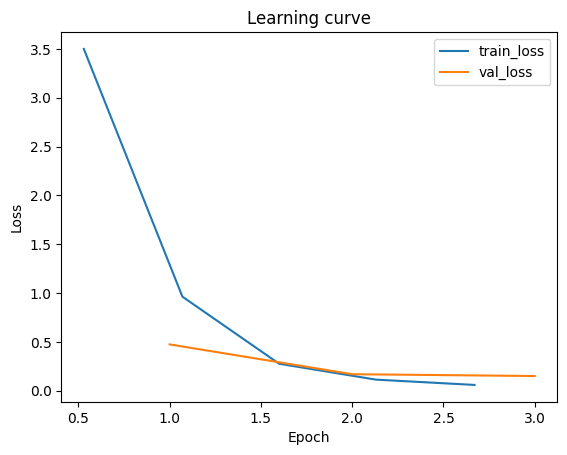

In [46]:
loss_values = [log_entry["loss"] for log_entry in trainer.state.log_history if "loss" in log_entry ]
epochs_train = [log_entry["epoch"] for log_entry in trainer.state.log_history if "loss" in log_entry and "epoch" in log_entry]
val_loss_values = [log_entry["eval_loss"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry ]
epochs_val =  [log_entry["epoch"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry and "epoch" in log_entry]

# Plot the loss graph
plt.plot(epochs_train,loss_values,label='train_loss')
plt.plot(epochs_val,val_loss_values,label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning curve")
plt.legend()
plt.show()

We plotted the validation and training loss to be sure that the model is not overfitting.

#### Saving the model

In [47]:
trainer.save_model()

#### Evaluate the model on the test dataset

In [48]:
tokenizer_loaded = AutoTokenizer.from_pretrained("./results")
model_loaded = AutoModelForSequenceClassification.from_pretrained("./results", num_labels=num_labels)

In [49]:
trainer2 = Trainer(
    model=model_loaded,
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer_loaded,
    data_collator=data_collator,
    compute_metrics=compute_metrics_eval
)

In [50]:
trainer2.evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.9695555555555555}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9708933761696947}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9695555555555557}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9695187949664357}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.1609278917312622,
 'eval_accuracy': {'accuracy': 0.9695555555555555},
 'eval_precision': {'precision': 0.9708933761696947},
 'eval_recall': {'recall': 0.9695555555555557},
 'eval_f1': {'f1': 0.9695187949664357},
 'eval_runtime': 33.4117,
 'eval_samples_per_second': 134.683,
 'eval_steps_per_second': 16.85}

The results are already comparable with those achieved during the first assignment in all the metrics. Let's try fine-tuning the language model on our dataset!

#### Domain adaptation

In [51]:
model = AutoModelForMaskedLM.from_pretrained(model_name)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##### Tokenizer

In [52]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenized_datasets = train_valid_test_dataset.map(
    preprocess_function_d_adapt, batched=True, remove_columns=["query", "label"]
)
tokenized_datasets

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 4500
    })
})

##### Pre-processing dataset

In [58]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 20691
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 4112
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 6116
    })
})

In [55]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

##### Fine-tune

In [61]:
batch_size = 64
# Show the training loss with every epoch
logging_steps = len(lm_datasets["train"]) // batch_size
model_name = model_name.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-clinc150",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    fp16=True,
    logging_steps=logging_steps,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

/content/bert-large-uncased-finetuned-clinc150 is already a clone of https://huggingface.co/FilippoComastri/bert-large-uncased-finetuned-clinc150. Make sure you pull the latest changes with `repo.git_pull()`.


In [62]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 2459.14


In [63]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,3.666600,2.958910
2,2.882900,2.750730
3,2.621600,2.625599


TrainOutput(global_step=972, training_loss=3.05598468937501, metrics={'train_runtime': 387.4759, 'train_samples_per_second': 160.198, 'train_steps_per_second': 2.509, 'total_flos': 903962426897376.0, 'train_loss': 3.05598468937501, 'epoch': 3.0})

In [64]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 14.23


We can see that the perplexity dropped by a lot so the fine-tuning worked!

In [66]:
trainer.push_to_hub()

Upload file runs/May24_11-18-12_01315b6119dc/events.out.tfevents.1684927114.01315b6119dc.332.14:   0%|        …

Upload file runs/May24_11-18-12_01315b6119dc/events.out.tfevents.1684927592.01315b6119dc.332.16:   0%|        …

To https://huggingface.co/FilippoComastri/bert-large-uncased-finetuned-clinc150
   73daf4d..66c039c  main -> main

   73daf4d..66c039c  main -> main

To https://huggingface.co/FilippoComastri/bert-large-uncased-finetuned-clinc150
   66c039c..3eb9dac  main -> main

   66c039c..3eb9dac  main -> main



'https://huggingface.co/FilippoComastri/bert-large-uncased-finetuned-clinc150/commit/66c039c88eb754a1564b85578fcb4258bfec68f1'

##### Fine tune the classification head

In [67]:
checkpoint = 'FilippoComastri/bert-large-uncased-finetuned-clinc150'


tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label = label_mapping)

tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)

metric = load_metric("accuracy")

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_train
)

Some weights of the model checkpoint at FilippoComastri/bert-large-uncased-finetuned-clinc150 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model check

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

In [68]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,2.585900,0.245828,0.959667
2,0.124300,0.149699,0.970333
3,0.037400,0.148575,0.970667


TrainOutput(global_step=2814, training_loss=0.5847601399153958, metrics={'train_runtime': 1503.2671, 'train_samples_per_second': 29.935, 'train_steps_per_second': 1.872, 'total_flos': 2663990449407264.0, 'train_loss': 0.5847601399153958, 'epoch': 3.0})

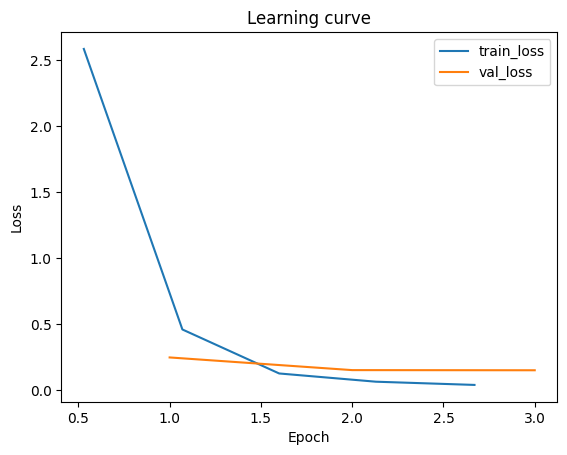

In [69]:
loss_values = [log_entry["loss"] for log_entry in trainer.state.log_history if "loss" in log_entry ]
epochs_train = [log_entry["epoch"] for log_entry in trainer.state.log_history if "loss" in log_entry and "epoch" in log_entry]
val_loss_values = [log_entry["eval_loss"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry ]
epochs_val =  [log_entry["epoch"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry and "epoch" in log_entry]

# Plot the loss graph
plt.plot(epochs_train,loss_values,label='train_loss')
plt.plot(epochs_val,val_loss_values,label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning curve")
plt.legend()
plt.show()

We plotted the validation and training loss to be sure that the model is not overfitting.

In [70]:
trainer.evaluate()

{'eval_loss': 0.14857544004917145,
 'eval_accuracy': 0.9706666666666667,
 'eval_runtime': 19.6025,
 'eval_samples_per_second': 153.041,
 'eval_steps_per_second': 9.591,
 'epoch': 3.0}

In [71]:
trainer.save_model()

##### Evaluate the model on the test dataset

In [72]:
tokenizer_loaded = AutoTokenizer.from_pretrained("./results")
model_loaded = AutoModelForSequenceClassification.from_pretrained("./results", num_labels=num_labels)

In [73]:
trainer2 = Trainer(
    model=model_loaded,
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer_loaded,
    data_collator=data_collator,
    compute_metrics=compute_metrics_eval
)

In [74]:
trainer2.evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.9702222222222222}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.971735675393187}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9702222222222224}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9702076205645422}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.1637600064277649,
 'eval_accuracy': {'accuracy': 0.9702222222222222},
 'eval_precision': {'precision': 0.971735675393187},
 'eval_recall': {'recall': 0.9702222222222224},
 'eval_f1': {'f1': 0.9702076205645422},
 'eval_runtime': 34.3115,
 'eval_samples_per_second': 131.151,
 'eval_steps_per_second': 16.409}

##### Let's evaluate the misclassifications.

In [75]:
prediction_scores, label_ids, metrics = trainer2.predict(test_dataset=tokenized_dataset["test"])

In [76]:
y_test = [label_mapping[key] for key in label_ids]
y_pred = [label_mapping[score_list.argmax()] for score_list in prediction_scores]
compare_misclassification(y_test, y_pred)

Percentage of 'pin_change' queries misclassified as'change_ai_name': 16.67%
Percentage of 'redeem_rewards' queries misclassified as'rewards_balance': 16.67%
Percentage of 'transactions' queries misclassified as'spending_history': 13.33%


## *XLM-RoBERTa* - fine-tuned on Amazon Massive

As a baseline we used distilled version of BERT (which was already used during the lesson) because it is a rather small model in terms of parameter count and yet can provide reasonable results.

#### Tokenizer

In [103]:
model_name = "cartesinus/xlm-r-base-amazon-massive-intent"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

In [104]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['query', 'label', 'input_ids', 'attention_mask'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['query', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['query', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4500
    })
})

#### Load the pretrained model

In [105]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, id2label = label_mapping, ignore_mismatched_sizes=True)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cartesinus/xlm-r-base-amazon-massive-intent and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([60, 768]) in the checkpoint and torch.Size([150, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([60]) in the checkpoint and torch.Size([150]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Fine-tune the classification head using a Trainer

In [106]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_train
)

In [107]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,3.742600,1.422066,0.876000
2,1.192500,0.555777,0.938667
3,0.515700,0.401630,0.946667


TrainOutput(global_step=2814, training_loss=1.525566307127518, metrics={'train_runtime': 845.5014, 'train_samples_per_second': 53.223, 'train_steps_per_second': 3.328, 'total_flos': 940999238299008.0, 'train_loss': 1.525566307127518, 'epoch': 3.0})

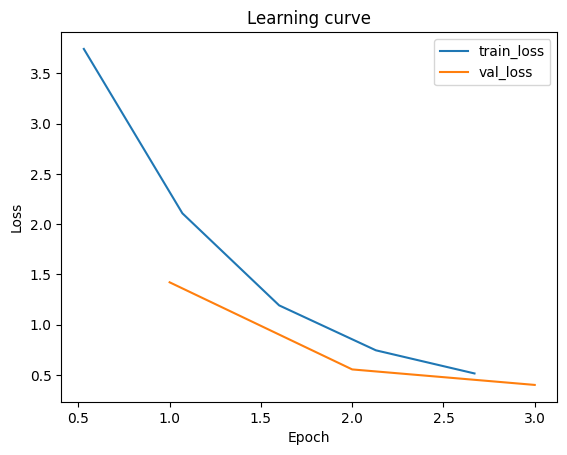

In [108]:
loss_values = [log_entry["loss"] for log_entry in trainer.state.log_history if "loss" in log_entry ]
epochs_train = [log_entry["epoch"] for log_entry in trainer.state.log_history if "loss" in log_entry and "epoch" in log_entry]
val_loss_values = [log_entry["eval_loss"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry ]
epochs_val =  [log_entry["epoch"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry and "epoch" in log_entry]

# Plot the loss graph
plt.plot(epochs_train,loss_values,label='train_loss')
plt.plot(epochs_val,val_loss_values,label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning curve")
plt.legend()
plt.show()

We plotted the validation and training loss to be sure that the model is not overfitting.

#### Saving the model

In [109]:
trainer.save_model()

#### Evaluate the model on the test dataset

In [110]:
tokenizer_loaded = AutoTokenizer.from_pretrained("./results")
model_loaded = AutoModelForSequenceClassification.from_pretrained("./results", num_labels=num_labels)

In [111]:
trainer2 = Trainer(
    model=model_loaded,
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer_loaded,
    data_collator=data_collator,
    compute_metrics=compute_metrics_eval
)

In [112]:
trainer2.evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.9402222222222222}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9433191093251918}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9402222222222222}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9397882498697957}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.4213303029537201,
 'eval_accuracy': {'accuracy': 0.9402222222222222},
 'eval_precision': {'precision': 0.9433191093251918},
 'eval_recall': {'recall': 0.9402222222222222},
 'eval_f1': {'f1': 0.9397882498697957},
 'eval_runtime': 9.9513,
 'eval_samples_per_second': 452.2,
 'eval_steps_per_second': 56.575}

The results are already comparable with those achieved during the first assignment in all the metrics. Let's try fine-tuning the language model on our dataset!

#### Domain adaptation

In [113]:
print(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

cartesinus/xlm-r-base-amazon-massive-intent


Some weights of the model checkpoint at cartesinus/xlm-r-base-amazon-massive-intent were not used when initializing XLMRobertaForMaskedLM: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForMaskedLM were not initialized from the model checkpoint at cartesinus/xlm-r-base-amazon-massive-intent and are newly initialized: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bi

##### Tokenizer

In [114]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenized_datasets = train_valid_test_dataset.map(
    preprocess_function_d_adapt, batched=True, remove_columns=["query", "label"]
)
tokenized_datasets

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 4500
    })
})

##### Pre-processing dataset

In [115]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 21844
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 4365
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 6471
    })
})

In [116]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

##### Fine-tune

In [117]:
batch_size = 64
# Show the training loss with every epoch
logging_steps = len(lm_datasets["train"]) // batch_size
model_name = model_name.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-clinc150",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    fp16=True,
    logging_steps=logging_steps,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

/content/xlm-r-base-amazon-massive-intent-finetuned-clinc150 is already a clone of https://huggingface.co/FilippoComastri/xlm-r-base-amazon-massive-intent-finetuned-clinc150. Make sure you pull the latest changes with `repo.git_pull()`.


In [118]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


>>> Perplexity: 464328993962.49


In [119]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,8.296800,6.637293
2,6.525200,6.232546
3,6.254600,6.103693


TrainOutput(global_step=1026, training_loss=7.023199726498848, metrics={'train_runtime': 936.1375, 'train_samples_per_second': 70.003, 'train_steps_per_second': 1.096, 'total_flos': 270195660247680.0, 'train_loss': 7.023199726498848, 'epoch': 3.0})

In [93]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 1.87


We can see that the perplexity dropped by a lot so the fine-tuning worked!

In [ ]:
trainer.push_to_hub()

##### Fine tune the classification head

In [ ]:
checkpoint = 'FilippoComastri/xlm-r-base-amazon-massive-intent-finetuned-clinc150'


tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label = label_mapping, ignore_mismatched_sizes=True)

tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)

metric = load_metric("accuracy")

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_train
)

Some weights of the model checkpoint at FilippoComastri/distilbert-base-uncased-finetuned-clinc150 were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at FilippoComastri/distilbert-base-uncased-finetuned-clinc150 and are newly

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,4.231500,1.845246,0.850333
2,1.379100,0.703728,0.922333
3,0.583100,0.507358,0.936667


TrainOutput(global_step=2814, training_loss=1.7560581350970454, metrics={'train_runtime': 199.2843, 'train_samples_per_second': 225.808, 'train_steps_per_second': 14.121, 'total_flos': 379476929590560.0, 'train_loss': 1.7560581350970454, 'epoch': 3.0})

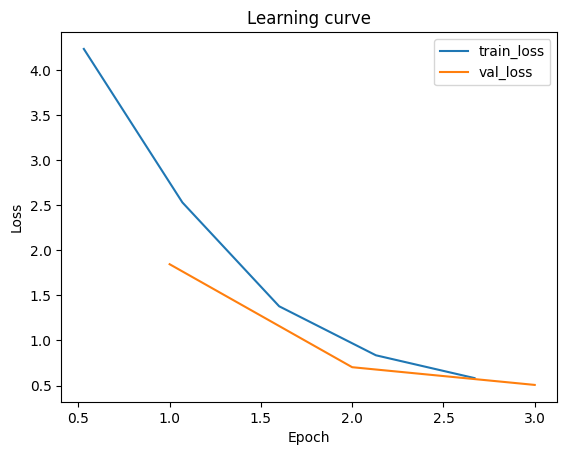

In [ ]:
loss_values = [log_entry["loss"] for log_entry in trainer.state.log_history if "loss" in log_entry ]
epochs_train = [log_entry["epoch"] for log_entry in trainer.state.log_history if "loss" in log_entry and "epoch" in log_entry]
val_loss_values = [log_entry["eval_loss"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry ]
epochs_val =  [log_entry["epoch"] for log_entry in trainer.state.log_history if "eval_loss" in log_entry and "epoch" in log_entry]

# Plot the loss graph
plt.plot(epochs_train,loss_values,label='train_loss')
plt.plot(epochs_val,val_loss_values,label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning curve")
plt.legend()
plt.show()

We plotted the validation and training loss to be sure that the model is not overfitting.

In [ ]:
trainer.evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.9346666666666666}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9414403666185198}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9346666666666666}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9338122537117185}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.5218574404716492,
 'eval_accuracy': {'accuracy': 0.9346666666666666},
 'eval_precision': {'precision': 0.9414403666185198},
 'eval_recall': {'recall': 0.9346666666666666},
 'eval_f1': {'f1': 0.9338122537117185},
 'eval_runtime': 2.8274,
 'eval_samples_per_second': 1061.061,
 'eval_steps_per_second': 66.493,
 'epoch': 3.0}

In [ ]:
trainer.save_model()

##### Evaluate the model on the test dataset

In [ ]:
tokenizer_loaded = AutoTokenizer.from_pretrained("/content/drive/MyDrive/NLP/xml-r-base-amazon-massive")
model_loaded = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/NLP/xml-r-base-amazon-massive", num_labels=num_labels)

In [ ]:
trainer2 = Trainer(
    model=model_loaded,
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer_loaded,
    data_collator=data_collator,
    compute_metrics=compute_metrics_eval
)

In [ ]:
trainer2.evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.9313333333333333}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9349745638664301}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9313333333333332}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.930536202503988}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.5266333222389221,
 'eval_accuracy': {'accuracy': 0.9313333333333333},
 'eval_precision': {'precision': 0.9349745638664301},
 'eval_recall': {'recall': 0.9313333333333332},
 'eval_f1': {'f1': 0.930536202503988},
 'eval_runtime': 5.0205,
 'eval_samples_per_second': 896.33,
 'eval_steps_per_second': 112.141}

##### Let's evaluate the misclassifications.

In [ ]:
prediction_scores, label_ids, metrics = trainer2.predict(test_dataset=tokenized_dataset["test"])

In [ ]:
y_test = [label_mapping[key] for key in label_ids]
y_pred = [label_mapping[score_list.argmax()] for score_list in prediction_scores]
compare_misclassification(y_test, y_pred)

Percentage of 'account_blocked' queries misclassified as'freeze_account': 16.67%
Percentage of 'change_ai_name' queries misclassified as'change_user_name': 23.33%
Percentage of 'change_user_name' queries misclassified as'change_ai_name': 43.33%
Percentage of 'change_volume' queries misclassified as'change_speed': 13.33%
Percentage of 'damaged_card' queries misclassified as'report_lost_card': 20.00%
Percentage of 'redeem_rewards' queries misclassified as'rewards_balance': 23.33%
Percentage of 'todo_list' queries misclassified as'shopping_list': 20.00%
Percentage of 'transactions' queries misclassified as'spending_history': 13.33%
Percentage of 'what_is_your_name' queries misclassified as'user_name': 40.00%
